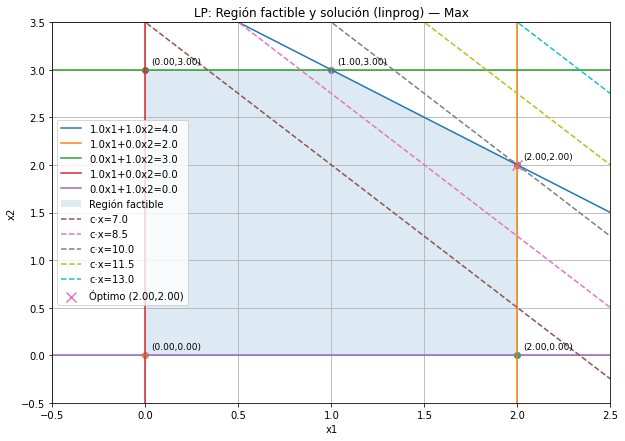

== Resultado del LP ==
Estatus solver: Optimization terminated successfully.
x* = (2, 2)
z* = 10  (max)
Restricciones activas en x*: a[0]·x = b[0]  (<= active); a[1]·x = b[1]  (<= active)

Vértices del polígono factible (ordenados):
  (0, 0)
  (2, 0)
  (2, 2)
  (1, 3)
  (0, 3)


In [4]:
# General LP visualizer & solver for 2 variables using SciPy linprog (if available).
# - You can EDIT the problem data in the "USER PROBLEM DEFINITION" block.
# - The script will:
#     * Solve the LP (maximize or minimize).
#     * Plot the feasible region (when it's a bounded polygon) and all boundary lines.
#     * Mark and annotate the optimal solution.

import numpy as np
import matplotlib.pyplot as plt

# ---------- USER PROBLEM DEFINITION ----------
# Example (the same LP we solved by hand):
#   Maximize z = 3 x1 + 2 x2
#   s.t.
#     x1 + x2 <= 4
#     x1 <= 2
#     x2 <= 3
#     x1 >= 0, x2 >= 0
#
maximize = True
c = np.array([3.0, 2.0])                 # objective coefficients
A_ub = np.array([[1.0, 1.0],             # <= constraints matrix
                 [1.0, 0.0],
                 [0.0, 1.0]])
b_ub = np.array([4.0, 2.0, 3.0])
A_eq = None                               # or e.g. np.array([[1.0, -1.0]])
b_eq = None                               # e.g. np.array([0.0])
bounds = [(0.0, None), (0.0, None)]       # (lower, upper) for x1 and x2; use None for +/-infinity
# --------------------------------------------

# ---------- Solve LP with scipy.optimize.linprog ----------
try:
    from scipy.optimize import linprog
except Exception as e:
    raise ImportError("SciPy is required for this demo. If not available, please let me know and I'll provide a fallback solver.") from e

c_lp = -c if maximize else c  # linprog minimizes
res = linprog(c_lp, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
status_ok = (res.status == 0)
x_opt = res.x if status_ok else None
z_opt = (c @ x_opt) if status_ok else None

# ---------- Build boundary lines for plotting ----------
# Each inequality a1 x1 + a2 x2 <= b contributes boundary a1 x1 + a2 x2 = b
# Each equality a1 x1 + a2 x2 = b contributes that line as well
# Bounds: x1 >= L or <= U leads to vertical lines x = L or x = U; similarly for x2.

def line_from_constraint(a, b):
    # Returns (a1, a2, b) representing a1*x + a2*y = b
    return (float(a[0]), float(a[1]), float(b))

boundary_lines = []  # list of (a1,a2,b)
if A_ub is not None and b_ub is not None:
    for ai, bi in zip(A_ub, b_ub):
        boundary_lines.append(line_from_constraint(ai, bi))
if A_eq is not None and b_eq is not None:
    for ai, bi in zip(A_eq, b_eq):
        boundary_lines.append(line_from_constraint(ai, bi))

# Bounds
def add_bound_lines(bounds):
    # bounds: [(L1,U1),(L2,U2)]
    (L1, U1), (L2, U2) = bounds
    if L1 is not None:
        boundary_lines.append((1.0, 0.0, float(L1)))  # x1 = L1
    if U1 is not None:
        boundary_lines.append((1.0, 0.0, float(U1)))  # x1 = U1
    if L2 is not None:
        boundary_lines.append((0.0, 1.0, float(L2)))  # x2 = L2
    if U2 is not None:
        boundary_lines.append((0.0, 1.0, float(U2)))  # x2 = U2

add_bound_lines(bounds)

# ---------- Compute all pairwise intersections of boundary lines ----------
def intersect(l1, l2, tol=1e-12):
    a1, b1, c1 = l1  # note: we use (a,b,c) but actually stored as (a1,a2,b)
    a2, b2, c2 = l2
    # Solve:
    #   a1 x + b1 y = c1
    #   a2 x + b2 y = c2
    M = np.array([[a1, b1],[a2, b2]], dtype=float)
    det = np.linalg.det(M)
    if abs(det) < tol:
        return None
    rhs = np.array([c1, c2], dtype=float)
    x, y = np.linalg.solve(M, rhs)
    return np.array([x, y], dtype=float)

candidates = []
for i in range(len(boundary_lines)):
    for j in range(i+1, len(boundary_lines)):
        pt = intersect(boundary_lines[i], boundary_lines[j])
        if pt is not None and np.all(np.isfinite(pt)):
            candidates.append(pt)
candidates = np.array(candidates) if candidates else np.empty((0,2))

# ---------- Feasibility test ----------
def is_feasible(x, A_ub, b_ub, A_eq, b_eq, bounds, tol=1e-9):
    x1, x2 = x
    # bounds
    (L1,U1),(L2,U2) = bounds
    if L1 is not None and x1 < L1 - tol: return False
    if U1 is not None and x1 > U1 + tol: return False
    if L2 is not None and x2 < L2 - tol: return False
    if U2 is not None and x2 > U2 + tol: return False
    # inequalities
    if A_ub is not None and b_ub is not None:
        if np.any(A_ub @ x - b_ub > tol): return False
    # equalities
    if A_eq is not None and b_eq is not None:
        if np.any(np.abs(A_eq @ x - b_eq) > tol): return False
    return True

feasible_pts = np.array([p for p in candidates if is_feasible(p, A_ub, b_ub, A_eq, b_eq, bounds)])

# Add bound-box corners if finite to help polygon closure (useful with only bounds)
(L1,U1),(L2,U2) = bounds
extra_corners = []
def add_corner(x1, x2):
    if np.all(np.isfinite([x1,x2])):
        if is_feasible(np.array([x1,x2]), A_ub, b_ub, A_eq, b_eq, bounds):
            extra_corners.append([x1,x2])
if L1 is not None and L2 is not None: add_corner(L1,L2)
if L1 is not None and U2 is not None: add_corner(L1,U2)
if U1 is not None and L2 is not None: add_corner(U1,L2)
if U1 is not None and U2 is not None: add_corner(U1,U2)

if extra_corners:
    feasible_pts = np.vstack([feasible_pts, np.array(extra_corners)])

# Deduplicate (within tol)
def dedup(points, tol=1e-9):
    out = []
    for p in points:
        if not any(np.linalg.norm(p-q) < tol for q in out):
            out.append(p)
    return np.array(out) if out else np.empty((0,2))

feasible_pts = dedup(feasible_pts, tol=1e-8)

# ---------- Order polygon (convex) for filling ----------
def order_polygon(points):
    if len(points) < 3:
        return points
    c = points.mean(axis=0)
    ang = np.arctan2(points[:,1]-c[1], points[:,0]-c[0])
    idx = np.argsort(ang)
    return points[idx]

poly = order_polygon(feasible_pts)

# ---------- Build plot limits ----------
def compute_limits(points, x_opt, margin=0.5):
    all_pts = []
    if points is not None and len(points)>0:
        all_pts.append(points)
    if x_opt is not None:
        all_pts.append(x_opt.reshape(1,2))
    if all_pts:
        P = np.vstack(all_pts)
        xmin, ymin = np.nanmin(P, axis=0) - margin
        xmax, ymax = np.nanmax(P, axis=0) + margin
        # respect bounds if finite
        (L1,U1),(L2,U2) = bounds
        if L1 is not None: xmin = min(xmin, L1 - margin)
        if U1 is not None: xmax = max(xmax, U1 + margin)
        if L2 is not None: ymin = min(ymin, L2 - margin)
        if U2 is not None: ymax = max(ymax, U2 + margin)
        xmin = max(xmin, -10)  # clamp to avoid extreme axes
        ymin = max(ymin, -10)
        xmax = min(xmax,  10)
        ymax = min(ymax,  10)
    else:
        xmin,ymin,xmax,ymax = 0,0,5,5
    return xmin,xmax,ymin,ymax

xmin,xmax,ymin,ymax = compute_limits(poly, x_opt)

x_line = np.linspace(xmin, xmax, 400)

# ---------- Plot figure ----------
plt.figure(figsize=(10,7))

# Draw boundary lines
def draw_line(a1,a2,b):
    # Draw a1 x + a2 y = b inside current x-limits
    if abs(a2) < 1e-12:  # vertical: x = b/a1
        x = b/a1
        plt.plot([x,x], [ymin,ymax], label=f"{a1:.1f}x1+{a2:.1f}x2={b:.1f}")
    else:
        y = (b - a1*x_line)/a2
        plt.plot(x_line, y, label=f"{a1:.1f}x1+{a2:.1f}x2={b:.1f}")

for (a1,a2,bv) in boundary_lines:
    draw_line(a1,a2,bv)

# Fill feasible polygon if bounded
if len(poly) >= 3:
    plt.fill(poly[:,0], poly[:,1], alpha=0.15, label="Región factible")
    # mark vertices
    for (vx,vy) in poly:
        plt.scatter([vx],[vy], marker='o')
        plt.annotate(f"({vx:.2f},{vy:.2f})", (vx,vy), textcoords="offset points", xytext=(6,6), fontsize=9)
else:
    # If not enough points to fill, still mark feasible intersections
    for (vx,vy) in feasible_pts:
        plt.scatter([vx],[vy], marker='o')
        plt.annotate(f"({vx:.2f},{vy:.2f})", (vx,vy), textcoords="offset points", xytext=(6,6), fontsize=9)

# Objective iso-lines near optimum
def plot_iso_lines(c, x_opt, levels=[-2,-1,0,1,2]):
    if x_opt is None: return
    z0 = c @ x_opt
    for d in levels:
        z = z0 + d
        # 3 cases: c2 != 0, else vertical; for general c=(c1,c2)
        c1, c2 = c
        if abs(c2) > 1e-12:
            y = (z - c1*x_line)/c2
            plt.plot(x_line, y, linestyle='--', label=f"c·x={z:.1f}")
        elif abs(c1) > 1e-12:
            x = z/c1
            plt.plot([x,x], [ymin,ymax], linestyle='--', label=f"c·x={z:.1f}")

if status_ok:
    plot_iso_lines(c, x_opt, levels=[-3,-1.5,0,1.5,3])

# Optimal point
if status_ok:
    plt.scatter([x_opt[0]], [x_opt[1]], marker='x', s=100, label=f"Óptimo ({x_opt[0]:.2f},{x_opt[1]:.2f})")
    #plt.annotate(f"z*={z_opt:.2f}", (x_opt[0], x_opt[1]), textcoords="offset points", xytext=(8,8), fontsize=5)

plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
#plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x1"); plt.ylabel("x2")
title = "LP: Región factible y solución (linprog)"
title += " — Max" if maximize else " — Min"
plt.title(title)
plt.legend(loc="best")
plt.grid()
plt.show()

# ---------- Text summary ----------
def active_constraints(x, A_ub, b_ub, A_eq, b_eq, bounds, tol=1e-7):
    act = []
    x1,x2 = x
    (L1,U1),(L2,U2) = bounds
    # bounds
    if L1 is not None and abs(x1-L1) <= tol: act.append(f"x1 = {L1}")
    if U1 is not None and abs(x1-U1) <= tol: act.append(f"x1 = {U1}")
    if L2 is not None and abs(x2-L2) <= tol: act.append(f"x2 = {L2}")
    if U2 is not None and abs(x2-U2) <= tol: act.append(f"x2 = {U2}")
    # inequalities
    if A_ub is not None and b_ub is not None:
        for i,(ai,bi) in enumerate(zip(A_ub,b_ub)):
            if abs(ai @ x - bi) <= tol:
                act.append(f"a[{i}]·x = b[{i}]  (<= active)")
    # equalities
    if A_eq is not None and b_eq is not None:
        for i,(ai,bi) in enumerate(zip(A_eq,b_eq)):
            if abs(ai @ x - bi) <= tol:
                act.append(f"Aeq[{i}]·x = beq[{i}]  (=)")
    return act

print("== Resultado del LP ==")
print(f"Estatus solver: {res.message}")
if status_ok:
    print(f"x* = ({x_opt[0]:.6g}, {x_opt[1]:.6g})")
    print(f"z* = {z_opt:.6g}  ({'max' if maximize else 'min'})")
    acts = active_constraints(x_opt, A_ub, b_ub, A_eq, b_eq, bounds)
    print("Restricciones activas en x*:", "; ".join(acts) if acts else "(ninguna)")
else:
    print("No se encontró solución óptima.")

# List polygon vertices
if len(poly) >= 1:
    print("\nVértices del polígono factible (ordenados):")
    for (vx,vy) in poly:
        print(f"  ({vx:.6g}, {vy:.6g})")
else:
    print("\nRegión posiblemente no acotada o insuficiente para formar polígono cerrado (se muestran intersecciones factibles si existen).")
